In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [2]:
#Notes:
#Determine if attacks can be grouped by type (DOS, User access, file delivery, portscan, etc)
    #Can named attacks be distinguished from each other within a type?
#Decide whether to remove or downsample DOS attacks...very unbalanced classes!
#Is it worth it to pursue cost/ease of mitigation vs. potential harm
#TCP vs UDP-UDP almost exclusively DOS attack
#3 models: Attack or not, Attack category, attack name
#SMURF is specific to ICMP
#Binary for UDP/ICMP? Or separate pipelines/models?



In [ ]:
#talking points
#UDP different now (voip)
#ICMP should be thresholded, not necessarily modelled
#Different atk types for different protocols
#Services unclear, likely look much different now as well


In [ ]:
#TODO:
#Pipeline:
    #get_dummies for flag and protocol
    #get_dummies and subset for service
#Train-test split!
    #separate dummies from numerical
    #standardscale numerical
    #Concat dummies back on
        #labelbinarizer on y_train, y_test if atk_categories
    #LassoCV fit
#predict
#score
#calculate RMSE

##### Sources
https://www.sciencedirect.com/science/article/pii/S2352864817300810

http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

https://www.ll.mit.edu/ideval/docs/index.html


In [3]:
#Import as dataframe
cyberdf = pd.read_csv('cyberdata.csv', header = None)


In [4]:
# Set column names
cyberdf.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack']


In [5]:
#Create dict of categories and names of attacks
atks_by_cat = {'DOS': ['land.','neptune.','pod.','satan.','smurf.','teardrop.'],
               'U2R': ['buffer_overflow.','loadmodule.','perl.','rootkit.'],
               'R2L': ['ftp_write.','guess_passwd.','imap.','phf.'],
               'PRB': ['ipsweep.','nmap.','portsweep.'],
               'SEC': ['multihop.','warezclient.','warezmaster.','rootkit.','spy.'],
               'NRM': ['normal.']}

In [6]:
#Function to change dtype to categorical for object columns
def convert_cols_to_category(df, col_list):
    '''Takes a dataframe and a list of the columns to be converted
       and converts the dtype of the columns to 'category'
       to save memory space
    '''
    for c in col_list:
        try:
            df[c] = df[c].astype('category')
        except:
            print("Could not convert {} to categorical.".format(c))    

In [7]:
def drop_uniform_cols(df):
    '''Takes a dataframe and removes columns where col.min()==col.max()
    '''
    for c in df.columns:
        if df[c].min() == df[c].max():
            df.drop(c, axis = 1, inplace = True)

In [8]:
drop_uniform_cols(cyberdf)

In [9]:
cols = ['protocol_type','service','flag']
convert_cols_to_category(cyberdf, cols)

In [96]:
svcs = cyberdf.groupby('service').count()['duration']
svcs.sort_values(ascending = False)

service
ecr_i          281400
private        110893
http            64293
smtp             9723
other            7237
domain_u         5863
ftp_data         4721
eco_i            1642
ftp               798
finger            670
urp_i             538
telnet            513
ntp_u             380
auth              328
pop_3             202
time              157
csnet_ns          126
remote_job        120
gopher            117
imap4             117
domain            116
discard           116
systat            115
iso_tsap          115
shell             112
echo              112
rje               111
whois             110
sql_net           110
printer           109
                ...  
uucp_path         106
uucp              106
bgp               106
klogin            106
ssh               105
supdup            105
nnsp              105
hostnames         104
login             104
daytime           103
efs               103
netbios_ns        102
link              102
pop_2             101
ld

In [63]:
cyberdf.dtypes

duration                          int64
protocol_type                  category
service                        category
flag                           category
src_bytes                         int64
dst_bytes                         int64
land                              int64
wrong_fragment                    int64
urgent                            int64
hot                               int64
num_failed_logins                 int64
logged_in                         int64
num_compromised                   int64
root_shell                        int64
su_attempted                      int64
num_root                          int64
num_file_creations                int64
num_shells                        int64
num_access_files                  int64
is_guest_login                    int64
count                             int64
srv_count                         int64
serror_rate                     float64
srv_serror_rate                 float64
rerror_rate                     float64


In [64]:
#create dfs for attack or not, attack category, attack name
y_n_df = cyberdf.copy()
atk_cats_df = cyberdf.copy()


In [65]:
#Replace values in y_n_df according to whether the traffic was normal or attack (0 for normal traffic)
y_n_df['attack'] = [0 if i == 'normal.' else 1 for i in y_n_df['attack']]

In [66]:
y_n_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


In [67]:
#Replace values in atk_cats_df according to attack category dict
for i in atks_by_cat.items():
    atk_cats_df['attack'].replace(i[1], i[0], inplace = True)

In [68]:
atk_cats_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,NRM
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,NRM
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,NRM
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,NRM
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,NRM


In [69]:
cyberdf[cyberdf['protocol_type'] == 'icmp'].groupby(by = 'attack').count()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
attack,,,,,,,,,,,,,,,,,,,,,
ipsweep.,1153,1153,1153,1153,1153,1153,1153,1153,1153,1153,...,1153,1153,1153,1153,1153,1153,1153,1153,1153,1153
nmap.,103,103,103,103,103,103,103,103,103,103,...,103,103,103,103,103,103,103,103,103,103
normal.,1288,1288,1288,1288,1288,1288,1288,1288,1288,1288,...,1288,1288,1288,1288,1288,1288,1288,1288,1288,1288
pod.,264,264,264,264,264,264,264,264,264,264,...,264,264,264,264,264,264,264,264,264,264
portsweep.,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
satan.,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
smurf.,280790,280790,280790,280790,280790,280790,280790,280790,280790,280790,...,280790,280790,280790,280790,280790,280790,280790,280790,280790,280790


#### Attack Names
buffer_overflow,
ftp_write,
guess_passwd,
imap,
ipsweep,
land,
loadmodule,
multihop,
neptune,
nmap,
normal,
perl,
phf,
pod,
portsweep,
rootkit,
satan,
smurf,
spy,
teardrop,
warezclient,
warezmaster

#### Attack Categories
'DOS', 'U2R', 'R2L', 'PRB', 'SEC', 'NRM'

Denial of Service

User to Remote

Remote to Local (user)

Probe

Secret

Normal

#### Attack names by cat
'DOS': ['land','neptune','pod','satan','smurf','teardrop'],
'U2R': ['buffer_overflow','loadmodule','perl','rootkit'],
'R2L': ['ftp_write','guess_passwd','imap','phf'],
'PRB': ['ipsweep','nmap','portsweep'],
'SEC': ['multihop','warezclient','warezmaster','rootkit','spy']


#### Column names
'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate'

In [80]:
#Drop a few highly correlated columns
y_n_df = y_n_df.drop(['rerror_rate','srv_rerror_rate','serror_rate','dst_host_serror_rate'], axis = 1)

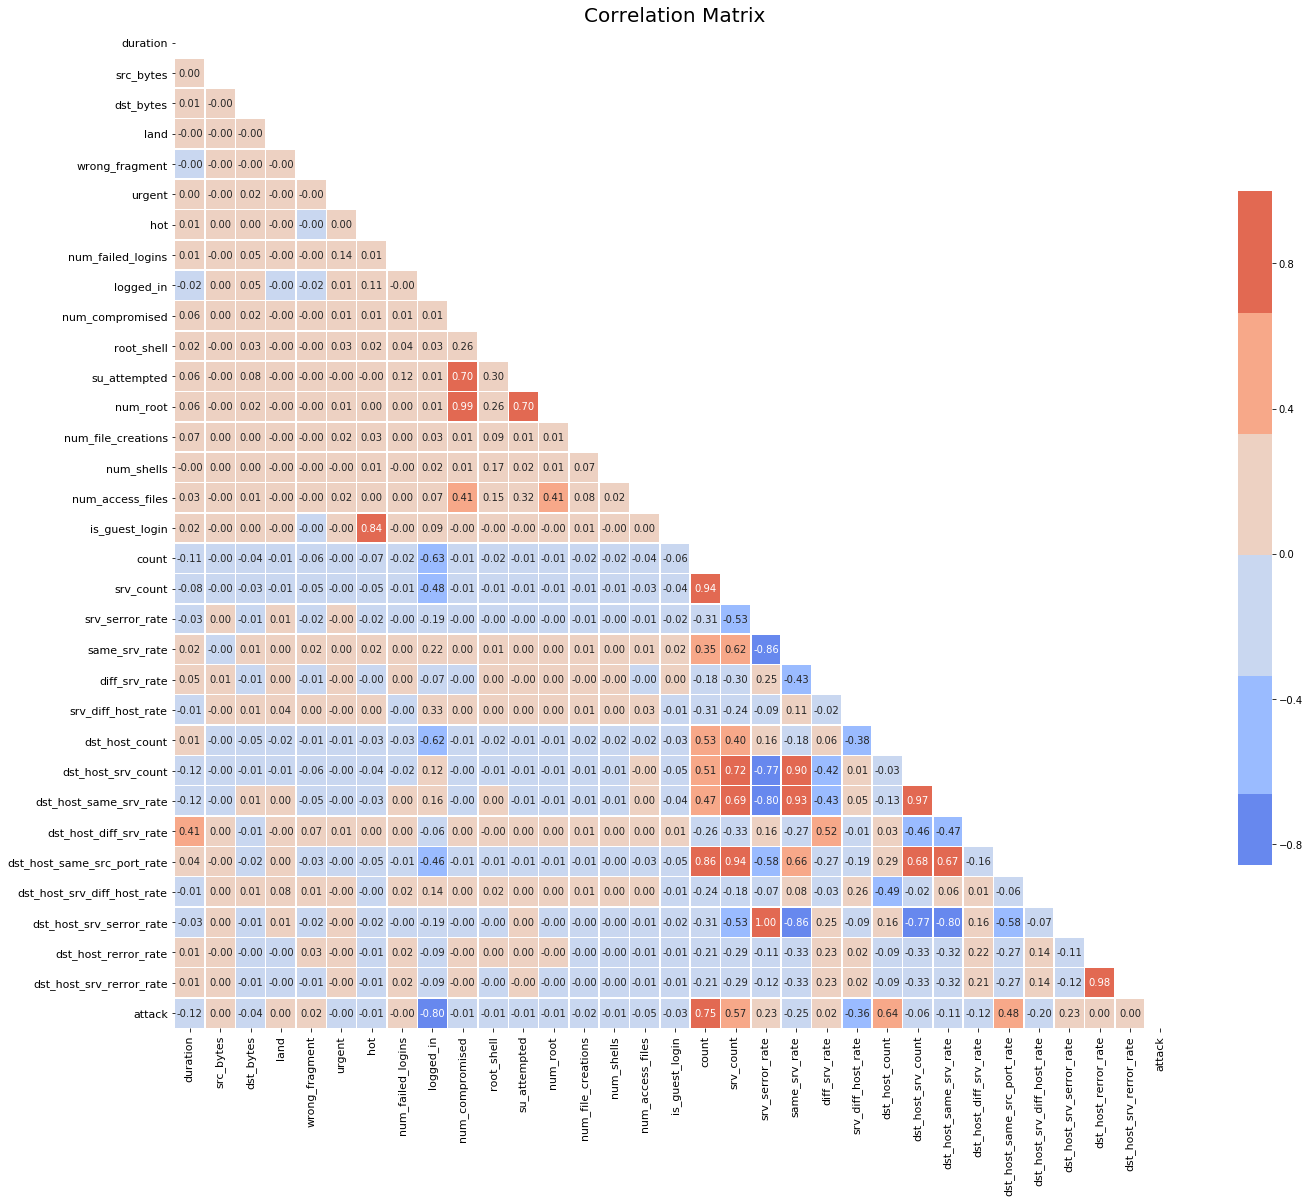

In [81]:
corr = y_n_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20,20))
cmap = sns.color_palette('coolwarm')
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5,
            yticklabels=True, annot=True, fmt='.2f', cbar_kws={'shrink':.5})
plt.title('Correlation Matrix', fontsize=20)
plt.xticks(rotation=90, fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()

In [43]:
ls = ['num_outbound_cmds','in_host_login']

dtype('O')

In [45]:
ls1 = []
for c in cyberdf.columns:
    if cyberdf[c].min() == cyberdf[c].max():
        ls1.append(c)

In [46]:
ls1

['num_outbound_cmds', 'is_host_login']

TypeError: ("unsupported operand type(s) for /: 'str' and 'int'", 'occurred at index duration')